In [116]:
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from geopandas.geoseries import *
import pandas as pd
import numpy as np
from geopandas.tools import sjoin
%matplotlib inline

In [28]:
with open("../Data/NewYorkGroundTruths.pkl" ,'r') as f:
    ratings = pkl.load(f)

In [97]:
ratings['513d9ea8fdc9f035870084a5'].keys()

['lat', 'rating', 'long']

In [30]:
NY = gpd.read_file("../Data/shapefiles/cb_2016_36_tract_500k.shp")

In [31]:
def check(point, polygon):
    if any(polygon.contains(point)):
        return True
    else:
        return False

def checkPoly(point,polygonArray):
    truths = [check(point , poly) for poly in polygonArray]
    return any(truths)

In [32]:
NY.head()

,AFFGEOID,ALAND,AWATER,COUNTYFP,GEOID,LSAD,NAME,STATEFP,TRACTCE,geometry
0,1400000US36051031000,6019437,0,051,36051031000,CT,310,36,031000,"POLYGON ((-77.841638 42.671857, -77.841531 42...."
1,1400000US36053030102,6232906,0,053,36053030102,CT,301.02,36,030102,"POLYGON ((-75.69125 43.09777099999999, -75.686..."
2,1400000US36055000200,1567317,58924,055,36055000200,CT,2,36,000200,"POLYGON ((-77.63571399999999 43.17025, -77.632..."
3,1400000US36055001000,1380452,0,055,36055001000,CT,10,36,001000,"POLYGON ((-77.592748 43.158266, -77.5916189999..."
4,1400000US36055002900,805895,0,055,36055002900,CT,29,36,002900,"POLYGON ((-77.59551499999999 43.152906, -77.59..."


In [80]:
len(NY['TRACTCE'])

4906

In [84]:
tractGeometry = {}
for idx , row in NY.iterrows():
    if int(row['TRACTCE']) not in tractGeometry:
        tractGeometry[int(row['TRACTCE'])] = row['geometry']

In [38]:
NY.keys()

Index([u'AFFGEOID',    u'ALAND',   u'AWATER', u'COUNTYFP',    u'GEOID',
           u'LSAD',     u'NAME',  u'STATEFP',  u'TRACTCE', u'geometry'],
      dtype='object')

In [341]:
prices = pd.read_csv("../Data/Revised_Notice_of_Property_Value__RNOPV_.csv")

In [342]:
prices.keys()

Index([u'MAILED DATE', u'BOROCODE', u'BLOCK', u'LOT', u'EASE', u'NAME  ',
       u'Address 1', u'Address 2 ', u'Address 3 ', u'City, State, Zip ',
       u'Country ', u'TAX CLASS', u'BLD Class', u'ORIGINAL MARKET VALUE',
       u'ORIGINAL ASSESSED VALUE', u'ORIGINAL EXEMPTION',
       u'ORIGINAL TRANSITIONAL  ASSESSED VALUE ',
       u'ORIGINAL TRANSITIONAL EXEMPTION', u'ORIGINAL TAXABLE VALUE',
       u'REVISED MARKET VALUE', u'REVISED ASSESSED VALUE',
       u'REVISED  EXEMPTION', u'REVISED TRANSITIONAL ASSESSED VALUE',
       u'REVISED TRANSITIONAL EXEMPTION', u'REVISED TAXABLE VALUE', u'RC 1',
       u'RC2', u'RC3', u'RC4', u'RC5', u'Borough', u'Postcode', u'Latitude',
       u'Longitude', u'Community Board', u'Council District ', u'Census Tract',
       u'BIN', u'BBL', u'NTA'],
      dtype='object')

In [343]:
prices['Borough'].unique()

array(['MANHATTAN', nan, 'BRONX    ', 'BROOKLYN ', 'QUEENS   ', 'STATEN IS'], dtype=object)

In [344]:
prices = prices[prices['Borough'] == 'STATEN IS']

In [345]:
len(prices)

1530

In [346]:
#Using gpxpy for calculating geographical distances

import gpxpy.geo


In [347]:
# prices = prices[prices['ORIGINAL TAXABLE VALUE'] > 200000]

In [348]:
prices = prices.dropna(subset=['Census Tract' , 'ORIGINAL MARKET VALUE' , 'ORIGINAL TAXABLE VALUE'])

In [349]:
len(prices)

1530

In [350]:
len(prices)

1530

In [351]:
tractPrices = {}

In [352]:
i =0

for idx , row in prices.iterrows():
    if int(row['Census Tract']) in tractGeometry:
        #if row['ORIGINAL MARKET VALUE'] > 100000:
            i+=1
            if row['Census Tract'] not in tractPrices:
                tractPrices[row['Census Tract']] = {}
                tractPrices[row['Census Tract']]['prices'] = []
                tractPrices[row['Census Tract']]['beauty'] = []
            tractPrices[row['Census Tract']]['prices'].append(row['ORIGINAL MARKET VALUE'])
            tractPrices[row['Census Tract']]['polygon'] = tractGeometry[row['Census Tract']]
    else:
        na.append(row['Census Tract'])
        

In [353]:
print i

948


In [354]:
np.median([len(tractPrices[i]['prices']) for i in tractPrices])

14.5

In [355]:
type(tractPrices[tractPrices.keys()[1]]['polygon'])

shapely.geometry.polygon.Polygon

In [356]:
for k in ratings:
    place = Point(ratings[k]['long'] , ratings[k]['lat'])
    beauty = ratings[k]['rating'].mu
    for k in tractPrices:
        if tractPrices[k]['polygon'].contains(place):
            tractPrices[k]['beauty'].append(beauty)
            
    

In [357]:
finalTractPrices = {}
for k in tractPrices:
    if len(tractPrices[k]['beauty']) > 0:
        finalTractPrices[k] = tractPrices[k]

In [360]:
print finalTractPrices

{201.0: {'prices': [722000.0, 627000.0, 507000.0, 501000.0, 391000.0, 285000.0, 656000.0, 32051.0, 404000.0], 'polygon': <shapely.geometry.polygon.Polygon object at 0x7fa983390090>, 'beauty': [15.116675580293611, 23.37467323427417, 22.1517039571353, 35.5265904310663, 28.22997740515289]}}


In [358]:
finalPrices = [np.median(finalTractPrices[k]['prices']) for k in finalTractPrices]
finalBeauty = [np.median(finalTractPrices[k]['beauty']) for k in finalTractPrices]

In [359]:
len(finalBeauty)

1

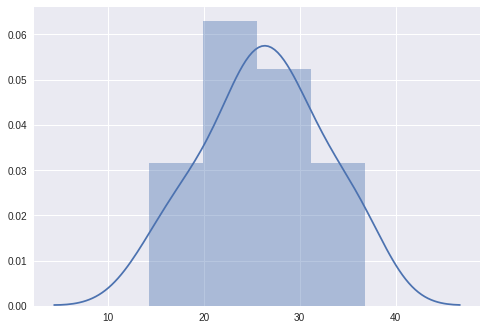

In [337]:
sns.distplot(finalBeauty)

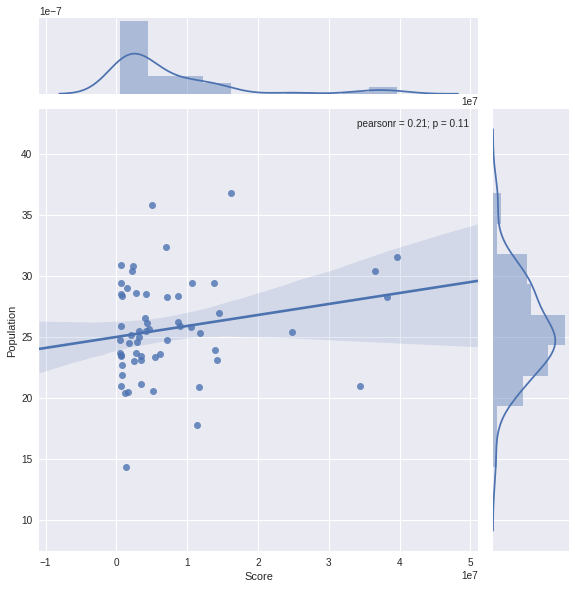

In [271]:
g = sns.jointplot(x=np.asarray(finalPrices), y=np.asarray(finalBeauty), kind="reg" , size=8);
g.set_axis_labels(xlabel='Score', ylabel='Population')